# Sentiment Analysis: Training a binary classifier with the IMDB Reviews Dataset

In this notebook, we will be building a sentiment classification model to distinguish between positive and negative movie reviews. We will train it on the [IMDB Reviews](http://ai.stanford.edu/~amaas/data/sentiment/) dataset.
Let's get started!


## Download the Dataset

First, we will need to fetch the dataset we will be working on. This is hosted via [Tensorflow Datasets](https://www.tensorflow.org/datasets), a collection of prepared datasets for machine learning.

In [1]:
import tensorflow_datasets as tfds

# Load the IMDB Reviews dataset
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

In [2]:
# Print information about the dataset
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir='/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
    

From the output, there is a total of 100,000 examples in the dataset and it is split into `train`, `test` and `unsupervised` sets. We will only use `train` and `test` sets because labeled examples are needed to train the model.

## Split the dataset


In [3]:
# Take 2 training examples and print its contents
for example in imdb['train'].take(2):
  print(example)

(<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on



 We will take all the `train` and `test` sentences and labels into separate lists so we can preprocess the text and feed it to the model later.

In [4]:
import numpy as np

# Get the train and test sets
train_data, test_data = imdb['train'], imdb['test']

# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Loop over all training examples and save the sentences and labels
for s,l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())

# Loop over all test examples and save the sentences and labels
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())

# Convert labels lists to numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


## Generate Padded Sequences

The text preprocessing steps will involve tokenizing the sentences and padding them to a uniform length. We've separated the parameters into its own code cell below so it will be easy for to tweak later if we want.

In [5]:
# Parameters

vocab_size = 10000
max_length = 120
embedding_dim = 16
trunc_type='post'
oov_tok = "<OOV>"

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, truncating=trunc_type)


## Build and Compile the Model

With the data already preprocessed,  we proceed to building our sentiment classification model.

In [7]:
import tensorflow as tf

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Setup the training parameters
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 160109 (625.43 KB)
Trainable params: 160109 (625.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Train the Model

Next, of course, is to train our model.

In [8]:
num_epochs = 8

# Train the model
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/8
782/782 [==============================] - 7s 8ms/step - loss: 0.5482 - accuracy: 0.7590 - val_loss: 0.4105 - val_accuracy: 0.8214
Epoch 2/8
782/782 [==============================] - 5s 6ms/step - loss: 0.3319 - accuracy: 0.8615 - val_loss: 0.3680 - val_accuracy: 0.8364
Epoch 3/8
782/782 [==============================] - 6s 7ms/step - loss: 0.2694 - accuracy: 0.8912 - val_loss: 0.3702 - val_accuracy: 0.8374
Epoch 4/8
782/782 [==============================] - 5s 7ms/step - loss: 0.2335 - accuracy: 0.9091 - val_loss: 0.3862 - val_accuracy: 0.8345
Epoch 5/8
782/782 [==============================] - 5s 7ms/step - loss: 0.2066 - accuracy: 0.9225 - val_loss: 0.4266 - val_accuracy: 0.8216
Epoch 6/8
782/782 [==============================] - 7s 8ms/step - loss: 0.1865 - accuracy: 0.9311 - val_loss: 0.4411 - val_accuracy: 0.8252
Epoch 7/8
782/782 [==============================] - 5s 6ms/step - loss: 0.1681 - accuracy: 0.9411 - val_loss: 0.4793 - val_accuracy: 0.8177
Epoch 8/8
782

## Results Visualization

Let's visualize the model's training history and how well it does on the test set

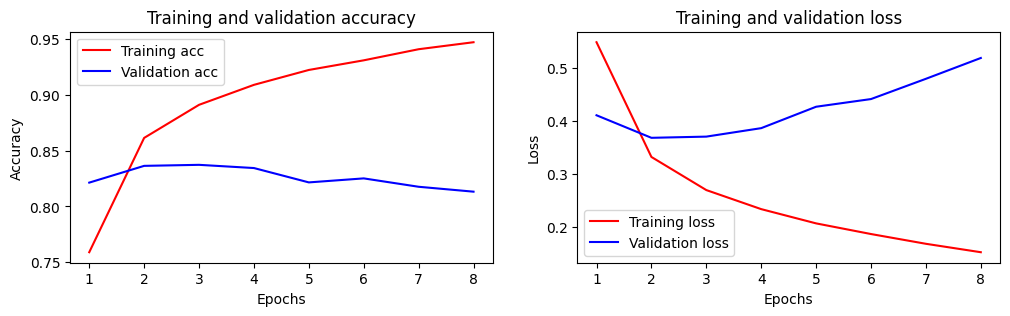

782/782 [==============================] - 2s 3ms/step - loss: 0.5185 - accuracy: 0.8133
Test Accuracy: 81.33%


In [11]:
import matplotlib.pyplot as plt

# Plot training history
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(12, 3))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r-', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r-', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot training history
plot_history(history)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(testing_padded, testing_labels_final)
print(f'Test Accuracy: {accuracy*100:.2f}%')

782/782 [==============================] - 1s 2ms/step


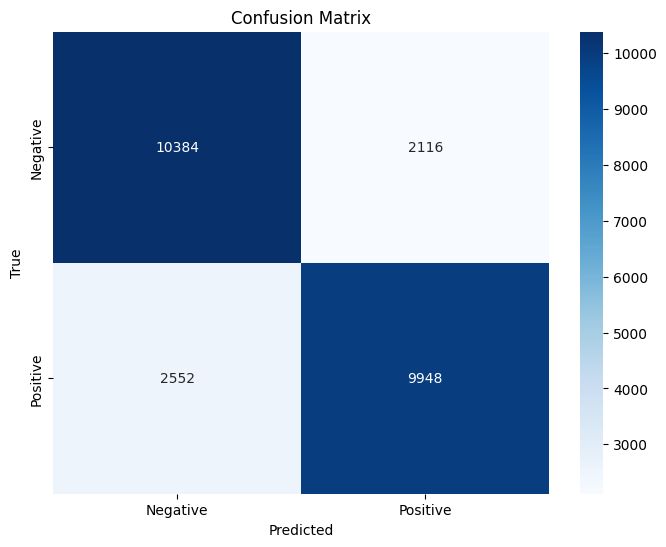

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.83      0.82     12500
           1       0.82      0.80      0.81     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000



In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Make predictions on the test set
y_pred_probs = model.predict(testing_padded)
y_pred = (y_pred_probs > 0.5).astype('int32')

# Call the function to plot confusion matrix
plot_confusion_matrix(testing_labels_final, y_pred)

# Display classification report
print('Classification Report:\n', classification_report(testing_labels_final, y_pred))

## WRITE-UP: Sentiment Classification Project Overview


## Project Introduction

The objective of this project is to develop a robust sentiment classification model capable of discerning between positive and negative sentiments in movie reviews. Leveraging the IMDB Reviews dataset, I employ advanced natural language processing and deep learning techniques to enhance the accuracy and interpretability of sentiment analysis.


## Dataset Loading and Preprocessing

The project begins with the meticulous loading of the IMDB Reviews dataset using TensorFlow Datasets. To ensure the data is aptly prepared for model training, comprehensive preprocessing steps are taken, including tokenization, sequence generation, and the creation of a word index.


## Neural Network Architecture

A sophisticated neural network architecture is employed to capture intricate patterns within textual data. The model comprises an embedding layer, a global average pooling layer, and dense layers with strategic activation functions, ultimately culminating in a binary classification layer using sigmoid activation.


## Model Training

The training phase involves compiling the model with a binary crossentropy loss function and the highly effective Adam optimizer. This step is pivotal for enabling the model to learn intricate sentiment-related nuances from the training dataset over a set number of epochs.


## Results Visualization and Analysis

To comprehensively assess the model's effectiveness, a suite of visualizations is incorporated. Training history plots, showcasing accuracy and loss over epochs, provide insights into the model's learning dynamics. Furthermore, the model undergoes rigorous evaluation on the test set, with visual aids such as a confusion matrix and a detailed classification report revealing its performance nuances.


## Project Conclusion

This project encapsulates a holistic approach to sentiment analysis, seamlessly integrating natural language processing, deep learning, and data visualization. By employing cutting-edge techniques and visualizations, the sentiment classification model not only achieves high accuracy but also demonstrates a robust understanding of sentiment patterns in movie reviews.
